In [82]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from keras.layers.core import Dense, Activation, Dropout


In [83]:
datapath = "DIS.csv"
df = pd.read_csv(datapath)
data = df['Close'].values.reshape(-1, 1)

def create_dataset(dataset, look_back=1): 
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        # print("X indices", i, ":", i+look_back)
        # print("y indices: ", i+look_back)
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

train_size = int(len(data) * 0.5)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [84]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((6567, 1, 240), (6567,), (6568, 1, 240), (6568,))

In [25]:
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
6567/6567 - 6s - loss: 4.9181e-05 - 6s/epoch - 964us/step
Epoch 2/100
6567/6567 - 6s - loss: 3.0204e-05 - 6s/epoch - 838us/step
Epoch 3/100
6567/6567 - 5s - loss: 2.3541e-05 - 5s/epoch - 811us/step
Epoch 4/100
6567/6567 - 6s - loss: 2.2401e-05 - 6s/epoch - 845us/step
Epoch 5/100
6567/6567 - 6s - loss: 2.0687e-05 - 6s/epoch - 845us/step
Epoch 6/100
6567/6567 - 5s - loss: 1.9312e-05 - 5s/epoch - 801us/step
Epoch 7/100
6567/6567 - 5s - loss: 1.9021e-05 - 5s/epoch - 821us/step
Epoch 8/100
6567/6567 - 5s - loss: 1.9708e-05 - 5s/epoch - 827us/step
Epoch 9/100
6567/6567 - 6s - loss: 1.7807e-05 - 6s/epoch - 858us/step
Epoch 10/100
6567/6567 - 6s - loss: 1.7650e-05 - 6s/epoch - 859us/step
Epoch 11/100
6567/6567 - 6s - loss: 1.6405e-05 - 6s/epoch - 883us/step
Epoch 12/100
6567/6567 - 6s - loss: 1.8511e-05 - 6s/epoch - 840us/step
Epoch 13/100
6567/6567 - 5s - loss: 1.6723e-05 - 5s/epoch - 822us/step
Epoch 14/100
6567/6567 - 6s - loss: 1.6918e-05 - 6s/epoch - 868us/step
Epoch 15/100
65

In [37]:
lstm_layer = model.layers[2]  # Assuming the LSTM layer is the first layer in the model
weights = lstm_layer.get_weights()
for i, weight in enumerate(weights):
    print(f"Parameter {i+1} shape: {weight.shape}")

Parameter 1 shape: (25, 1)
Parameter 2 shape: (1,)


In [39]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


206/206 [==============================] - 0s 698us/step


(6568, 1)

In [43]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [46]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.51 RMSE
Test Score: 29.23 RMSE


In [58]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

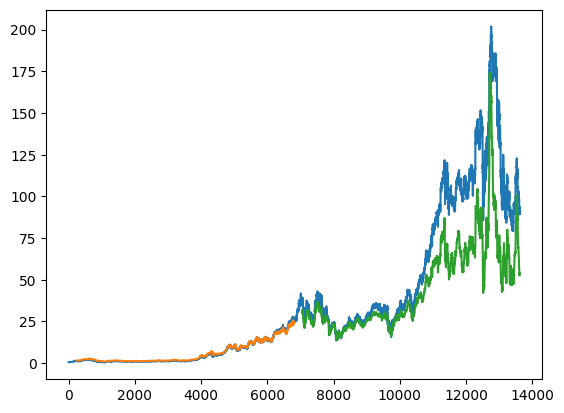

In [60]:
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [85]:
import torch 
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


In [86]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((6567, 1, 240), (6567,), (6568, 1, 240), (6568,))

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Model(nn.Module): 
    def __init__(self, input_size, hidden_size, num_layers, output_size): 
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # out, _ = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [88]:
model = Model(input_size=look_back, hidden_size=25, num_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainXT = torch.from_numpy(trainX).float().to(device)
trainYT = torch.from_numpy(trainY).float().to(device)
testXT = torch.from_numpy(testX).float().to(device)
testYT = torch.from_numpy(testY).float().to(device)


In [89]:
n_epochs = 2000
for epoch in range(n_epochs): 
    model.train()
    optimizer.zero_grad()
    output = model(trainXT)
    loss = loss_fn(output, trainYT)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

c:\Users\nq9093\AppData\Local\anaconda3\envs\ML\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6567])) that is different to the input size (torch.Size([6567, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/2000, Loss: 0.00497296592220664
Epoch 2/2000, Loss: 0.004062953405082226
Epoch 3/2000, Loss: 0.003390355035662651
Epoch 4/2000, Loss: 0.0029404025990515947
Epoch 5/2000, Loss: 0.0026810660492628813
Epoch 6/2000, Loss: 0.0025582220405340195
Epoch 7/2000, Loss: 0.0025044840294867754
Epoch 8/2000, Loss: 0.002460898132994771
Epoch 9/2000, Loss: 0.0023937688674777746
Epoch 10/2000, Loss: 0.002293364843353629
Epoch 11/2000, Loss: 0.0021642467472702265
Epoch 12/2000, Loss: 0.002017715945839882
Epoch 13/2000, Loss: 0.001866225735284388
Epoch 14/2000, Loss: 0.0017204153118655086
Epoch 15/2000, Loss: 0.0015890219947323203
Epoch 16/2000, Loss: 0.0014770823763683438
Epoch 17/2000, Loss: 0.0013869574759155512
Epoch 18/2000, Loss: 0.0013183217961341143
Epoch 19/2000, Loss: 0.0012686233967542648
Epoch 20/2000, Loss: 0.0012337671360000968
Epoch 21/2000, Loss: 0.001209102920256555
Epoch 22/2000, Loss: 0.0011901508551090956
Epoch 23/2000, Loss: 0.0011733225546777248
Epoch 24/2000, Loss: 0.001156

In [96]:
model.eval()

(6568,)

Train Score: 0.03 RMSE
Test Score: 0.36 RMSE


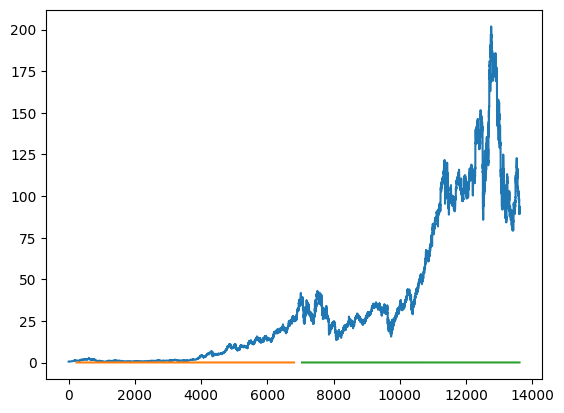

In [97]:
trainPredict = model(trainXT)
testPredict = model(testXT)

trainPredict = trainPredict.cpu().detach().numpy().reshape(-1, 1)
testPredict = testPredict.cpu().detach().numpy().reshape(-1, 1)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict.reshape(-1, 1)

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict.reshape(-1, 1)

plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
